# Setup the Koch v1.1

Date: 2025-03-06

Author: Hannes Ill, TaiRo (TUM.ai Robotics Taskforce)

Summary of examples/7_getting_started_with_real_world_robot.md with some troubleshooting additions we encountered.

**If you have already configured your motors the first time**, you can streamline the process by directly running the **teleoperate** script (which is detailed further in the tutorial):
````sh
python lerobot/scripts/control_robot.py \
  --robot.type=koch \
  --control.type=teleoperate

It will automatically:
1. Identify any missing calibrations and initiate the calibration procedure.
2. Connect the robot and start teleoperation.

## 1. Control your motors with DynamixelMotorsBus

You can use the DynamixelMotorsBus to communicate with the motors connected as a chain to the corresponding USB bus. This class leverages the Python Dynamixel SDK to facilitate reading from and writing to the motors.

### 1.1. Configure Motors (done)

Set the motor IDs, baudrate, etc. (see docs)
This will be stored in the persistent memory of each motor.

After all of your motors are configured properly, you're ready to plug them all together in a daisy-chain as shown in the original video.

You can **verify** this by going into the Dynamixel Wizard 2.0 and doing a Scan. This is also a good **sanity check** to ensure that your motors are all connected. 

Make sure that the motors are not connected to anything else (e.g. the script). If one of the motors cannot be found, unplug it completely and plug it back in. This sometimes happens with the follower arm.

Use these settings for the scan:

- Protocol: 2.0
- Ports: The two USB Single Serial ports
- All baudrates
- IDs between 0 and 10 (to save time)

### 1.2. Instantiate the DynamixelMotorsBus

To begin, create two instances of the DynamixelMotorsBus, one for each arm, using their corresponding USB ports (e.g. DynamixelMotorsBus(port="/dev/tty.usbmodem575E0031751").

To **find the correct ports for each arm**, run the utility script twice:
```sh
python lerobot/scripts/find_motors_bus_port.py

Example output when identifying the follower arm's port (e.g., /dev/tty.usbmodem575E0032081, or possibly /dev/ttyACM1 on Linux)

For my Mac, I get:
```sh
/dev/tty.usbmodem58760433811 (Follower)
/dev/tty.usbmodem58760435371 (Leader)
```

Troubleshooting: On Linux, you might need to give access to the USB ports by running this command with your ports:
```sh
sudo chmod 666 [PORT]
sudo chmod 666 [PORT]

Next, we need to map the names of the motors to their index and model. 

**Important:** Update the ports in the code below **and** in lerobot/robot_devices/robots/configs.py KochRobotConfig to match your ports.

The code below is to connect manually to the motors here, the config file is to connect in the scripts to the motors automatically.

We connect manually to make 100% sure the mapping is correct. If we successfully have done step 1.1., the mapping will already be correct and this step is just a **sanity check**. Else, the manual steps below prompt you to set everything correctly.

**Run the code below**

In [57]:
from lerobot.common.robot_devices.motors.configs import DynamixelMotorsBusConfig
from lerobot.common.robot_devices.motors.dynamixel import DynamixelMotorsBus

leader_config = DynamixelMotorsBusConfig(
    port="/dev/tty.usbmodem58760435371",
    motors={
        # name: (index, model)
        "shoulder_pan": (1, "xl330-m077"),
        "shoulder_lift": (2, "xl330-m077"),
        "elbow_flex": (3, "xl330-m077"),
        "wrist_flex": (4, "xl330-m077"),
        "wrist_roll": (5, "xl330-m077"),
        "gripper": (6, "xl330-m077"),
    },
)

follower_config = DynamixelMotorsBusConfig(
    port="/dev/tty.usbmodem58760433811",
    motors={
        # name: (index, model)
        "shoulder_pan": (1, "xl430-w250"),
        "shoulder_lift": (2, "xl430-w250"),
        "elbow_flex": (3, "xl330-m288"),
        "wrist_flex": (4, "xl330-m288"),
        "wrist_roll": (5, "xl330-m288"),
        "gripper": (6, "xl330-m288"),
    },
)

# Now we can instantiate two objects of the DynamixelMotorsBus class with these motor mappings
# The DynamixelMotorsBus objects are used to read and write to the motors.
# E.g. they are used in the script of 1.1. to set the motor ID and baudrate 
leader_arm = DynamixelMotorsBus(leader_config)
follower_arm = DynamixelMotorsBus(follower_config)

Now let's check the leader arm first. Run this command:

In [58]:
leader_arm.connect()

Question: If we have a connection, we don't disconnect and connect a new arm instance, does the previous connection get disconnected automatically?

If nothing happens, the connection is successful. Else you will see an output like this:

```md
Read failed due to communication error on port /dev/tty.usbmodem575E0032081 for group_key ID_shoulder_pan_shoulder_lift_elbow_flex_wrist_flex_wrist_roll_gripper: [TxRxResult] There is no status packet!

/!\ A configuration issue has been detected with your motors:
If this is the first time you are using these motors, press enter to configure your motors... but before verify that all the cables are connected the proper way. If you find an issue, before making a modification, kill the python process, unplug the power cord to not damage the motors, rewire correctly, then plug the power again and relaunch the script.

Motor indices detected: {9600: [1]}

1. Unplug the power cord
2. Plug/unplug minimal number of cables to only have the first 1 motor(s) (['shoulder_pan']) connected.
3. Re-plug the power cord
Press Enter to continue...

*Follow the procedure*

Setting expected motor indices: [1, 2, 3, 4, 5, 6]
````

If the configuration process fails, you may need to do the configuration process via the Dynamixel Wizard

And the same for the follower arm:

In [59]:
follower_arm.connect()

### 1.3. Read and write to the motors

Check if the IDs of both arms get printed correctly (1, 2, 3, 4, 5, 6). This may take half a minute:

In [5]:
print(leader_arm.find_motor_indices())
print(follower_arm.find_motor_indices())

100%|██████████| 252/252 [00:16<00:00, 14.95it/s]


[1, 2, 3, 4, 5, 6]


100%|██████████| 252/252 [00:16<00:00, 14.96it/s]

[1, 2, 3, 4, 5, 6]


Let's also check if we can read the position of the motors:

In [60]:
leader_pos = leader_arm.read("Present_Position")
follower_pos = follower_arm.read("Present_Position")
print(leader_pos)
print(follower_pos)

[2179 4509 1924 3263  861 2545]
[2178  865 1586 1682 3078 2062]


Note: It is not critical that the motors have the same / a similar position. To account for this, we will use the **calibration** procedure in the next step.

First, let's try to move the motors of the follower arm a little bit.

**Attention**: Try to position the follower arm in a way that each motor has some range of movement in both directions!

In [61]:
# Enable torque
from lerobot.common.robot_devices.motors.dynamixel import TorqueMode

follower_arm.write("Torque_Enable", TorqueMode.ENABLED.value)

# Get the current position
position = follower_arm.read("Present_Position")

In [62]:
# Update first motor (shoulder_pan) position by +X steps
position[0] += 100
follower_arm.write("Goal_Position", position)

In [63]:
# Update all motors position by -X steps
position -= 30
follower_arm.write("Goal_Position", position)

In [64]:
# Update gripper by +X steps
position[-1] += 100
follower_arm.write("Goal_Position", position[-1], "gripper")

Good to know: The connection between a DynamixelMotorBus object and the motors is not exclusive. We can have multiple DynamixelMotorBus objects connected to the same motors:

In [65]:
# Instantiate a new DynamixelMotorsBus object
follower_arm2 = DynamixelMotorsBus(follower_config)
follower_arm2.connect()

# Both objects move the same motors
position[0] -=100
follower_arm2.write("Goal_Position", position)
position[0] += 100
follower_arm2.write("Goal_Position", position)

# Nothing happens because the code runs too fast
# We need to add a small delay to see it move to the right and back left to the original position
from time import sleep
position[0] -=100
follower_arm2.write("Goal_Position", position)
sleep(0.1)
position[0] += 100
follower_arm2.write("Goal_Position", position)

The DynamixelMotorsBus' destructor will automatically disconnect from the motors when the object is deleted.

However, it is still good practice to disconnect the motors manually when we are done with the program.

In [66]:
follower_arm2.disconnect()

Also, we can disable the torque of the motors when we are done with the program, disconnecting fromthem does not disable the torque.

In [67]:
# Disable torque
follower_arm.write("Torque_Enable", TorqueMode.DISABLED.value)

In [68]:
# Finally, disconnect both arms
leader_arm.disconnect()

In [69]:
follower_arm.disconnect()

Nice, we can now read from the motors of the leader arm and also control the motors of the follower arm 🥳

Let's calibrate the motors of both arms so that we can teleoperate the follower arm with the leader arm.

## 2. Teleoperate with ManipulatorRobot

### 2.1. Instantiate a ManipulatorRobot

We can combine the leader_config and the follower_config we defined above to create a ManipulatorRobot

In [117]:
from lerobot.common.robot_devices.robots.configs import KochRobotConfig
from lerobot.common.robot_devices.robots.manipulator import ManipulatorRobot

robot_config = KochRobotConfig(
    leader_arms={"main": leader_config},
    follower_arms={"main": follower_config},
    cameras={},  # We don't use any camera for now
)
robot = ManipulatorRobot(robot_config)

Now we can connect to the robot with robot.connect()

If we do this for the first time, we will be prompted to calibrate the motors of both arms – first the follower, then the leader.

To do this we have to move both arms in three specific positions: 
- zero position (all motors at ~0°)
- rotated position (all motors at ~90°)
- rest position (aligning the starting position of both arms)

Pictures of these positions can be found in the docs or under media/koch/

The calibration will be stored in two json files in the .cache directory of your current path.

The calibration script will prompt you to move the specified arm in the specified position and then press enter (6x).

In [118]:
robot.connect()

Connecting main follower arm.
Connecting main leader arm.
Activating torque on main follower arm.
Wrong motor position range detected for shoulder_lift. Expected to be in nominal range of [-180, 180] degrees (a full rotation), with a maximum range of [-270, 270] degrees to account for joints that can rotate a bit more, but present value is 419.765625 degree. This might be due to a cable connection issue creating an artificial 360 degrees jump in motor values. You need to recalibrate by running: `python lerobot/scripts/control_robot.py calibrate`


Troubleshooting: If we somehow mess up the calibration, just delete the .cache directory and run robot.connect() again.

### 2.2. Teleoperate the robot with the ManipulatorRobot

We can now read the orientation of each motor. If both arms are in a similar position, the leader_pos and follower_pos should be similar.

In [119]:
leader_pos = robot.leader_arms["main"].read("Present_Position")
follower_pos = robot.follower_arms["main"].read("Present_Position")

print(leader_pos)
print(follower_pos)

[-5.888672  59.32617   87.36328   63.984375   7.5585938 34.277344 ]
[-4.921875  59.765625  83.49609   62.05078    6.8554688 34.189453 ]


Troubleshooting: If the values are not similar, perhaps the arms are not in a similar enough position. To check for sure run the teleoperation script below and see if the arms move in sync. After the teleoperation, if we rerun the code above, the values should be similar.

If this does not help, try to unplug the arms and redo the process. You can always kind of debug your problem with the Dynamixel Wizard.

This code lets the follower arm follow the leader arm for 30 seconds with 200Hz

Questions: What frequency is optimal? What happens if we increase the frequency? What happens if we decrease the frequency?

In [88]:
import tqdm
seconds = 30
frequency = 200
for _ in tqdm.tqdm(range(seconds*frequency)):
    leader_pos = robot.leader_arms["main"].read("Present_Position")
    robot.follower_arms["main"].write("Goal_Position", leader_pos)

100%|██████████| 6000/6000 [00:29<00:00, 206.68it/s]


ManipulatorRobot also provides the method teleop_step() which we can use to shorten the code:
```python
for _ in tqdm.tqdm(range(seconds*frequency)):
    robot.teleop_step()
```

It provides a `record_data` argument with which we can specify to record the teleoperation:



In [89]:
leader_pos = robot.leader_arms["main"].read("Present_Position")
follower_pos = robot.follower_arms["main"].read("Present_Position")
observation, action = robot.teleop_step(record_data=True)

print(follower_pos)
print(observation)
print(leader_pos)
print(action)

[-5.9765625 71.89453   88.1543    68.81836    7.734375  34.541016 ]
{'observation.state': tensor([-5.9766, 71.8945, 88.1543, 68.8184,  7.7344, 34.5410])}
[-5.888672  59.501953  87.36328   63.896484   7.5585938 34.277344 ]
{'action': tensor([-5.8887, 59.5020, 87.3633, 63.9844,  7.5586, 34.2773])}


teleop_step() can also asynchronously record frames from multiple cameras and include them in the observation dictionary as "observation.images.CAMERA_NAME". This feature will be covered in more detail in the next section.

For now, let's disconnect the robot

### 2.3. Disconnect the robot

In [90]:
robot.disconnect()

**Important:** This does again not disable the torque of the motors. It only stops the connection between the ManipulatorRobot object and the motors.

We need to disable the torque of the motors manually – Either unplug the power cord or use the following code:





In [91]:
from lerobot.common.robot_devices.motors.dynamixel import TorqueMode
# Connect to the arms
follower_arm.connect()
leader_arm.connect()

# Disable torque
follower_arm.write("Torque_Enable", TorqueMode.DISABLED.value)
leader_arm.write("Torque_Enable", TorqueMode.DISABLED.value)

# Disconnect the arms
follower_arm.disconnect()
leader_arm.disconnect()

## 3. Add your cameras with OpenCVCamera

We will use the USB camera Logitech C920 HD Pro for this example. Any camera that OpenCV supports should work.

FYI: There is a way to use your phone as a camera, which seems quite simple for Mac and iPhone users.

To connect a camera, we need to create an OpenCVCamera with the index to the camera we want to use:

```python
camera = OpenCVCamera(camera_index=0)
```

If we have one camera, usually, the index is 0. If we add one more camera, the indeces will usually be 0 and 1, etc.

To be sure which camera has which index, we can run the following script:



In [3]:
!python ../../lerobot/common/robot_devices/cameras/opencv.py \
    --images-dir camera_index_test

Mac or Windows detected. Finding available camera indices through scanning all indices from 0 to 60
Camera found at index 0
Camera found at index 1
OpenCV: out device of bound (0-1): 2
OpenCV: camera failed to properly initialize!
[03/08 19:13:50.993578][info][466612][Context.cpp:69] Context created with config: default config!
[03/08 19:13:50.993598][info][466612][Context.cpp:74] Context work_dir=/Users/hannesill/Developer/lerobot_v2/tairo/docs
[03/08 19:13:50.993600][info][466612][Context.cpp:77] 	- SDK version: 1.9.4
[03/08 19:13:50.993601][info][466612][Context.cpp:78] 	- SDK stage version: main
[03/08 19:13:50.993603][info][466612][Context.cpp:82] get config EnumerateNetDevice:false
[03/08 19:13:50.993604][info][466612][MacPal.cpp:36] createObPal: create MacPal!
[03/08 19:13:50.997481][info][466612][MacPal.cpp:104] Create PollingDeviceWatcher!
[03/08 19:13:50.997493][info][466612][DeviceManager.cpp:15] Current found device(s): (0)
[03/08 19:13:50.997497][info][466612][Pipeline.cpp

Afterwards, go to the camera_index_test directory and check the images to match your camera(s) to the correct index.

Note: Some cameras may take a few seconds to warm up, and the first frame might be black or green.

Now we can create an OpenCVCamera object with the correct index.

(1080, 1920, 3)
uint8


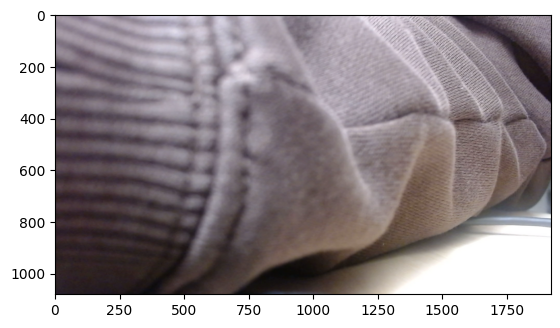

In [14]:
from lerobot.common.robot_devices.cameras.configs import OpenCVCameraConfig
from lerobot.common.robot_devices.cameras.opencv import OpenCVCamera
import matplotlib.pyplot as plt
import time

config = OpenCVCameraConfig(camera_index=0) # The index of the camera we want to connect to
camera = OpenCVCamera(config)
camera.connect()

time.sleep(1) # In case the camera needs to warm up

color_image = camera.read()

print(color_image.shape)
print(color_image.dtype)

plt.imshow(color_image)

camera.disconnect()

In my case, the Loitech Webcam has index 0 and my MacBook's camera has index 1. Both produce images of the shape (1080, 1920, 3).

Certain cameras allow to give some parameters. Let's try for our cameras if that works:

(480, 640, 3)
uint8
2
254


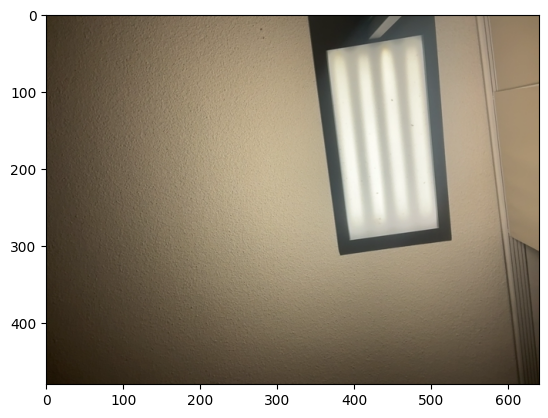

In [18]:
config = OpenCVCameraConfig(camera_index=1, fps=30, width=640, height=480)
camera = OpenCVCamera(config)
camera.connect()

time.sleep(1)  # In case the camera needs to warm up

color_image = camera.read()

print(color_image.shape)
print(color_image.dtype)
print(color_image.min())
print(color_image.max())

plt.imshow(color_image)

camera.disconnect()

### 3.2. Instantiate a ManipulatorRobot with cameras

In [120]:
robot = ManipulatorRobot(
    KochRobotConfig(
        leader_arms={"main": leader_config},
        follower_arms={"main": follower_config},
        calibration_dir=".cache/calibration/koch",
        cameras={
            "usb": OpenCVCameraConfig(0, fps=30, width=640, height=480),
            "macbook": OpenCVCameraConfig(1, fps=30, width=640, height=480),
        },
    )
)
robot.connect()

Connecting main follower arm.
Connecting main leader arm.
Activating torque on main follower arm.
Wrong motor position range detected for shoulder_lift. Expected to be in nominal range of [-180, 180] degrees (a full rotation), with a maximum range of [-270, 270] degrees to account for joints that can rotate a bit more, but present value is 419.765625 degree. This might be due to a cable connection issue creating an artificial 360 degrees jump in motor values. You need to recalibrate by running: `python lerobot/scripts/control_robot.py calibrate`


Troubleshooting: If you get a "Wrong motor position range detected" message, you can probably ignore it.

**Question: Why does this message appear?**

As a result, teleop_step(record_data=True) will return a frame for each camera following the pytorch "channel first" convention but we keep images in uint8 with pixels in range [0,255] to easily save them.

In [121]:
observation, action = robot.teleop_step(record_data=True)
print(observation["observation.images.macbook"].shape)
print(observation["observation.images.usb"].shape)
print(observation["observation.images.macbook"].min().item())
print(observation["observation.images.macbook"].max().item())

torch.Size([480, 640, 3])
torch.Size([480, 640, 3])
0
255


The output should look like this:
```shell
torch.Size([3, 480, 640])
torch.Size([3, 480, 640])
0
255
```

In [ ]:
# Let's disconnect the robot
robot.disconnect()

## 4. Teleoperate with the control_robot.py script

Instead of manually running the python code in a terminal window, you can use lerobot/scripts/control_robot.py to instantiate your robot by providing the robot configurations via command line and control your robot with various modes as explained next.

Try running this code to teleoperate your robot (if you dont have a camera, keep reading). It may take a while to start:

In [ ]:
!python ../../lerobot/scripts/control_robot.py \
  --robot.type=koch \
  --control.type=teleoperate

INFO 2025-03-07 18:37:16 ol_robot.py:371 {'control': {'display_cameras': True, 'fps': None, 'teleop_time_s': None},
 'robot': {'calibration_dir': '.cache/calibration/koch',
           'cameras': {'laptop': {'camera_index': 0,
                                  'channels': 3,
                                  'color_mode': 'rgb',
                                  'fps': 30,
                                  'height': 480,
                                  'mock': False,
                                  'rotation': None,
                                  'width': 640},
                       'phone': {'camera_index': 1,
                                 'channels': 3,
                                 'color_mode': 'rgb',
                                 'fps': 30,
                                 'height': 480,
                                 'mock': False,
                                 'rotation': None,
                                 'width': 640}},
           'follower_arms': {'ma

It contains:
- time and file name and line number of the print statement
- dt: 5.12 (195.1hz) which is the "delta time" or the number of milliseconds spent between the previous call to robot.teleop_step() and the current one, associated with the frequency (5.12 ms equals 195.1 Hz) ; note that you can control the maximum frequency by adding fps as argument such as --fps 30.
- dtRlead: 4.93 (203.0hz) which is the number of milliseconds it took to read the position of the leader arm using leader_arm.read("Present_Position").
- dtWfoll: 0.22 (4446.9hz) which is the number of milliseconds it took to set a new goal position for the follower arm using follower_arm.write("Goal_position", leader_pos) ; note that writing is done asynchronously so it takes less time than reading.

If you don't have a camera or don't want to use it for the teleoperation, you can run:

In [ ]:
!python ../../lerobot/scripts/control_robot.py \
  --robot.type=koch \
  --robot.cameras='{}' \
  --control.type=teleoperate

INFO 2025-03-07 18:55:03 ol_robot.py:371 {'control': {'display_cameras': True, 'fps': None, 'teleop_time_s': None},
 'robot': {'calibration_dir': '.cache/calibration/koch',
           'cameras': {},
           'follower_arms': {'main': {'mock': False,
                                      'motors': {'elbow_flex': [3,
                                                                'xl330-m288'],
                                                 'gripper': [6, 'xl330-m288'],
                                                 'shoulder_lift': [2,
                                                                   'xl430-w250'],
                                                 'shoulder_pan': [1,
                                                                  'xl430-w250'],
                                                 'wrist_flex': [4,
                                                                'xl330-m288'],
                                                 'wrist_roll': [5,
        

That's it! 🥳🎉

You now know:
* how to connect your robot to the motors
* how to teleoperate the robot with code
* how to add camerad to your robot and control them
* how to use the control_robot.py script to do all of the above in one go